In [31]:
from processing_utils import get_train_data, encode_smiles_column_of, prune_dataset_lines, cross_validation_of
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Pipeline Application

In [35]:
raw_dataset = pd.read_csv('./dataset/data.csv')
dataset = encode_smiles_column_of(
    prune_dataset_lines(
        raw_dataset,
        remove_nan_lines=False,
        remove_nan_cols=True,
        remove_duplicates=True,
        in_favour_of_col='Energy_(kcal/mol)'
    ),
    strategy='count_encoding')

### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, y_train, X_test, y_test = get_train_data(
    dataset,
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
    validation=False
)

LR_Energy_ = LinearRegression()
LR_Energy_ = LR_Energy_.fit(X_train, y_train[:, 0])

LR_EnergyDG = LinearRegression()
LR_EnergyDG = LR_EnergyDG.fit(X_train, y_train[:, 1])

print("mse(y_train_Energy_, y_pred_train_Energy_) =",
      mean_squared_error(y_train[:, 0], LR_Energy_.predict(X_train)))
print("mse(y_test_Energy_, y_pred_test_Energy_) =",
      mean_squared_error(y_test[:, 0], LR_Energy_.predict(X_test)))
print("==================================")

print("Test prediction mse =", mean_squared_error(
    y_test[:5, 0], LR_Energy_.predict(X_test[:5, :])))
print("Actual Real target values : \n", y_test[:5, 0])
print("Sample predicted vector : \n", LR_Energy_.predict(X_test[:5, :]))
print("==================================")

print("mse(y_train_EnergyDG, y_pred_train_EnergyDG) =",
      mean_squared_error(y_train[:, 1], LR_EnergyDG.predict(X_train)))
print("mse(y_test_EnergyDG, y_pred_test_EnergyDG) =",
      mean_squared_error(y_test[:, 1], LR_EnergyDG.predict(X_test)))
print("==================================")

print("Test prediction mse =", mean_squared_error(
    y_test[:5, 1], LR_EnergyDG.predict(X_test[:5, :])))
print("Actual Real target values : \n", y_test[:5, 1])
print("Sample predicted vector : \n", LR_EnergyDG.predict(X_test[:5, :]))


mse(y_train_Energy_, y_pred_train_Energy_) = 225038880.9681848
mse(y_test_Energy_, y_pred_test_Energy_) = 223344267.85235864
Test prediction mse = 73215971.0064291
Actual Real target values : 
 [-59706.92619 -47543.32019 -68798.74981 -49408.60872 -47553.85245]
Sample predicted vector : 
 [-57152.49266674 -56868.52039774 -57047.50158864 -56945.7325298
 -56368.34593566]
mse(y_train_EnergyDG, y_pred_train_EnergyDG) = 224310883.4600905
mse(y_test_EnergyDG, y_pred_test_EnergyDG) = 222597834.84555495
Test prediction mse = 72898150.6165127
Actual Real target values : 
 [-59624.47091 -47436.17274 -68690.93172 -49380.13357 -47484.06102]
Sample predicted vector : 
 [-57053.00396011 -56767.72482203 -56949.10491614 -56847.19933859
 -56268.87056058]


In [25]:
print("Cross validation error LR_Energy_ =", cross_validation_of( LR_Energy_, X_train, y_train))
print("Cross Validation of EnergyGD =", cross_validation_of( LR_EnergyDG, X_train, y_train))

Cross validation error LR_Energy_ = 226025216.8555986
Cross Validation of EnergyGD = 226025216.8555986


#### Performances wrt. training dataset size

In [45]:
from utils import split_array
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from MeanPredictor import MeanPredictor
import random

N_TRIALS = 10
mses = [[] for _ in range(N_TRIALS)]
r2_scores = [[] for _ in range(N_TRIALS)]
percentages = list(np.arange(0.1, 1, 0.01))

baseline_mses = [[] for _ in range(N_TRIALS)]
baseline_r2_scores = [[] for _ in range(N_TRIALS)]

for k in range(N_TRIALS):
    seed = random.randint(0, 10000)
    random_state = np.random.RandomState(seed)
    #seed = 7732
    for p in percentages:
        # print(f"p={p}, seed={seed}")
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )

        X_tr = X_train.sample(frac=p, random_state=random_state, replace=False)
        y_tr = y_train.sample(frac=p, random_state=random_state, replace=False)
        lr = LinearRegression()
        features_scaler = StandardScaler()
        target_scaler = StandardScaler()
        lr = lr.fit(features_scaler.fit_transform(X_tr),
                    target_scaler.fit_transform(y_tr))
        y_pred = lr.predict(features_scaler.transform(X_test))
        mses[k].append(mean_squared_error(target_scaler.transform(y_test), y_pred))
        r2_scores[k].append(r2_score(target_scaler.transform(y_test), y_pred))


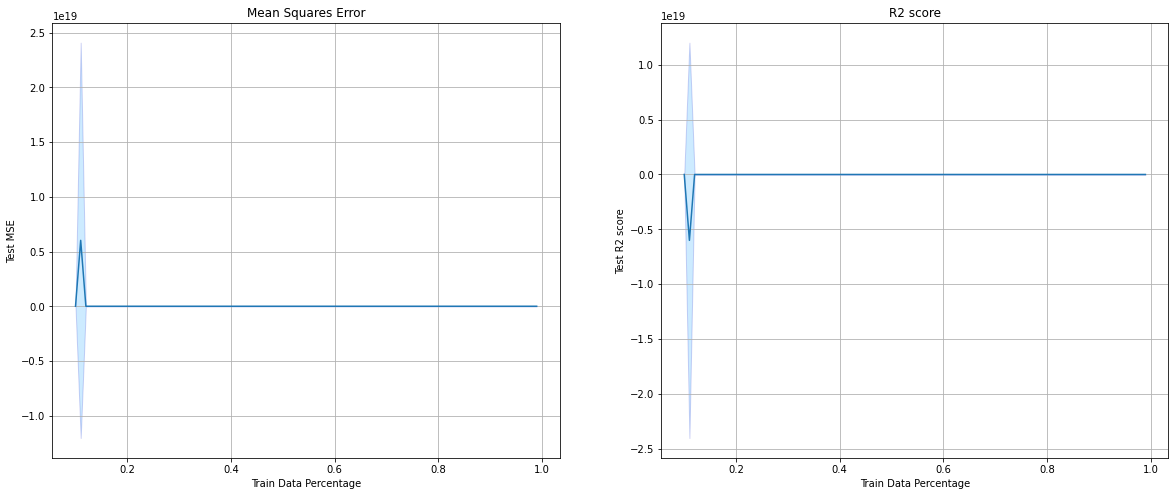

In [46]:

from pathlib import Path

#np.save('path/linear_reg_mses_var_percentage', mses)
#np.save('path/linear_reg_scores_var_percentage', r2_scores)

path = Path('./results/logistic_regression')
mses = np.load(path/'linear_reg_mses_var_percentage.npy')
r2_scores = np.load(path/'linear_reg_scores_var_percentage.npy')

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Mean Squares Error")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test MSE")
plt.grid(True)

final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)
plt.semilogy(percentages, final_mses, label='Linear Regression')
plt.legend()
plt.fill_between(percentages, final_mses - mses_error, final_mses + mses_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.subplot(1, 2, 2)
plt.title("R2 score")
plt.xlabel("Train Data Percentage")
plt.ylabel("Test R2 score")
plt.grid(True)
plt.yscale('linear')
final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)
plt.plot(percentages, final_r2_score, label='Linear Regression')
plt.legend()
plt.fill_between(percentages, final_r2_score - r2_score_error, final_r2_score + r2_score_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')


#### Performances wrt. added noise

In [53]:
N_TRIALS = 2
mses = [[] for _ in range(N_TRIALS)]
r2_scores = [[] for _ in range(N_TRIALS)]
scale_factors = np.arange(0.1, 4, 0.1)

for k in range(N_TRIALS):
    for scale_factor in scale_factors:
        seed = random.randint(0, 10000)
        X_train, y_train, X_test, y_test = get_train_data(
            dataset,
            targets_columns=['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'],
            random_state=random_state,
            as_numpy=False,
            validation=False
        )
        
        features_scaler = StandardScaler()
        target_scaler = StandardScaler()
        lr = LinearRegression()

        X_train.iloc[:3] += np.random.normal(scale=scale_factor, size=X_train.iloc[:3].shape)

        lr.fit(features_scaler.fit_transform(X_train), target_scaler.fit_transform(y_train))
        y_pred = lr.predict(features_scaler.transform(X_test))
        mses[k].append(mean_squared_error(target_scaler.transform(y_test), y_pred))
        r2_scores[k].append(r2_score(target_scaler.transform(y_test), y_pred))

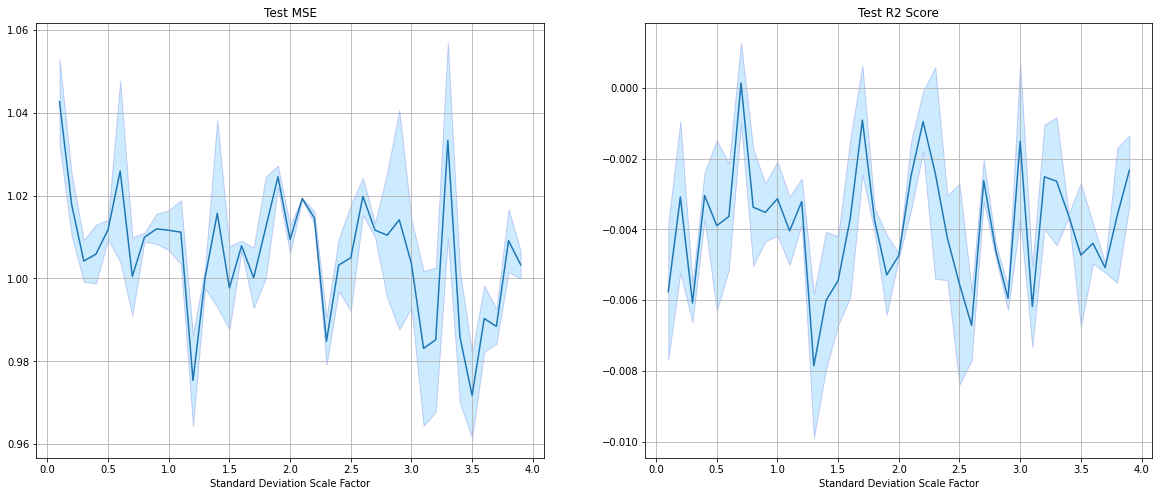

In [54]:
scale_factors = np.arange(0.1, 4, 0.1)

#np.save(path/'linear_reg_mses_var_noise', mses)
#np.save(path/'linear_reg_scores_var_noise', r2_scores)

mses = np.load(path/'linear_reg_mses_var_noise.npy')
r2_scores = np.load(path/'linear_reg_scores_var_noise.npy')

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Test MSE")
plt.xlabel("Standard Deviation Scale Factor")
final_mses = np.mean(mses, axis=0)
mses_error = np.std(mses, axis=0)
plt.grid(True)
plt.plot(scale_factors, final_mses)
plt.fill_between(scale_factors, final_mses - mses_error, final_mses + mses_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')


plt.subplot(1, 2, 2)
plt.title("Test R2 Score")
plt.xlabel("Standard Deviation Scale Factor")
final_r2_score = np.mean(r2_scores, axis=0)
r2_score_error = np.std(r2_scores, axis=0)
plt.grid(True)
plt.plot(scale_factors, final_r2_score)
plt.fill_between(scale_factors, final_r2_score - r2_score_error, final_r2_score + r2_score_error, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')